In [12]:
!pip install torchsummary

In [1]:
# This cell imports necessary libraries and modules for the project.

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
from torchsummary import summary

In [2]:
# This cell defines the function 'prepare_data' to load and preprocess the dataset using PyTorch.
# The function returns DataLoaders for training, validation, and testing.

def prepare_data(batch_size):
    #Transform to normalize the data 
    transform = Compose([ToTensor(),Normalize((0.5),(0.5))])
    #Download and load the training and test datasets
    trainset = MNIST(root='MNIST', download=True, train=True, transform=transform)
    testset = MNIST(root='MNIST', download=True, train=False, transform=transform)

    trainset_size = round(len(trainset)* 0.8)
    validset_size = len(trainset) - trainset_size
    trainset, validset = random_split(trainset, [trainset_size, validset_size])

    train_d1 = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_d1 = DataLoader(validset, batch_size=batch_size, shuffle=False)
    test_d1 = DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    return train_d1, valid_d1, test_d1

Definition d'un model

In [3]:
# This cell defines a neural network architecture (MLP) using PyTorch.
# It includes an initialization of layers and the forward pass.

class MLP(nn.Module):
    def __init__(self, input_dim, N1, N2, output_dim):
        super(MLP, self).__init__()
        self.f1=nn.Flatten()
        self.fc1= nn.Linear(input_dim,N1)
        self.fc2= nn.Linear(N1,N2)
        self.fc3= nn.Linear(N2,output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.f1(x)
        out=self.relu(self.fc1(x))
        out=self.relu(self.fc2(out))
        out=self.fc3(out)
        return out
        

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
model1 = MLP(784, 250, 128, 10)
print(model1)
summary(model1.to(device), input_size=(1, 28, 28))

MLP(
  (f1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 250]         196,250
              ReLU-3                  [-1, 250]               0
            Linear-4                  [-1, 128]          32,128
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 229,668
Trainable params: 229,668
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.88
Estimated Total S

In [36]:
# This cell defines functions for training the model and evaluating its performance.
# The 'train_modal' function handles the training process over multiple epochs.
# The 'evaluation' function computes the model's accuracy on the test dataset.

def validation(model,device,valid_dl ,criterion):
  model.eval() # sets the module in evaluation mode
  loss_total=0
  with torch.no_grad():
    for batch_idx, data in enumerate(valid_dl):
      inputs = data[0].to(device)
      targets = data[1].to(device)
      output=model(inputs)
      loss=criterion(output,targets)
      loss_total+=loss.item()
  return loss_total/len(valid_dl)

In [50]:
# This cell defines functions for training the model and evaluating its performance.
# The 'train_modal' function handles the training process over multiple epochs.
# The 'evaluation' function computes the model's accuracy on the test dataset.

# Taining
def train_modal(model, device, epochs, optimizer, criterion, train_dl, valid_dl):
  train_loss = 100; patience = 2; triggertimes = 0
  train_losses = []  # List to store the loss for each epoch


  for epoch in range(1, epochs+1):
    model.train() # sets the module in traininng mode

    loss_per_epoch = 0.0
    for batch_idx, data in enumerate(train_dl):
      inputs = data[0].to(device)
      targets = data[1].to(device)

      # Zero the gradients
      optimizer.zero_grad()

      # Forward and backward propagation
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      # Show progress
      if batch_idx % 100 == 0 or batch_idx == len(train_dl):
        print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, batch_idx, len(train_dl), loss.item()))
        loss_per_epoch += loss.item()
    # Calculate the average loss for this epoch and store it
    avg_epoch_loss = loss_per_epoch / len(train_dl)
    train_losses.append(avg_epoch_loss)
    current_loss = validation(model, device, valid_dl, criterion)
    if current_loss > train_loss:
      triggertimes += 1
      print('trigger times', triggertimes)
      if triggertimes >= patience:
        print('Preform Early stopping!')
        return model, train_losses
    else:
      triggertimes = 0
      print('trigger times', triggertimes)
      train_loss = current_loss

  return model, train_losses


In [48]:
# This cell defines functions for training the model and evaluating its performance.
# The 'train_modal' function handles the training process over multiple epochs.
# The 'evaluation' function computes the model's accuracy on the test dataset.

def evaluation(model, device, test_dl):
  model.eval()
  total=0.0; correct=0.0
  with torch.no_grad():
    for data in test_dl:
      inputs = data[0].to(device)
      targets = data[1].to(device)
      outputs=model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()
    accuracy=correct/total
    return accuracy

MLP(
  (f1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)
[1/100, 0/750] loss: 2.2906623
[1/100, 100/750] loss: 0.50533968
[1/100, 200/750] loss: 0.31271839
[1/100, 300/750] loss: 0.31118351
[1/100, 400/750] loss: 0.22693701
[1/100, 500/750] loss: 0.19793862
[1/100, 600/750] loss: 0.29810539
[1/100, 700/750] loss: 0.15944208
trigger times 0
[2/100, 0/750] loss: 0.078947991
[2/100, 100/750] loss: 0.20772232
[2/100, 200/750] loss: 0.22682497
[2/100, 300/750] loss: 0.16550545
[2/100, 400/750] loss: 0.25685301
[2/100, 500/750] loss: 0.061833117
[2/100, 600/750] loss: 0.088185899
[2/100, 700/750] loss: 0.058373034
trigger times 0
[3/100, 0/750] loss: 0.17883624
[3/100, 100/750] loss: 0.046154
[3/100, 200/750] loss: 0.15746674
[3/100, 300/750] loss: 0.053503856
[3/100, 400/750] loss: 0.09641213
[3/100, 50

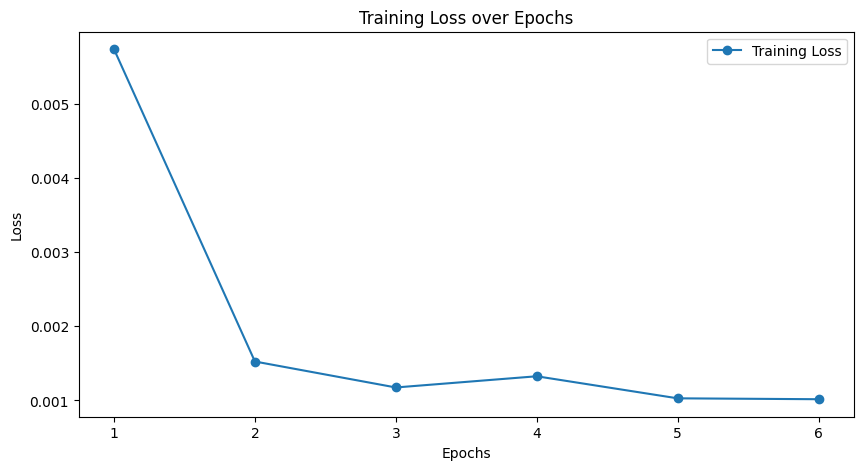

In [51]:
# This cell defines the function 'prepare_data' to load and preprocess the dataset using PyTorch.
# The function returns DataLoaders for training, validation, and testing.

def main(epochs = 100, batch_size = 64, lr = 0.002, wd=1.e-4):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  criterion = nn.CrossEntropyLoss()
  model = MLP(784, 128, 64, 10)
  model = model.to(device) # Move model before creating optimizer
  print(model)
  optimizer = Adam(model.parameters(), lr = lr, weight_decay = wd) # with weight decay

  # Data preparation
  train_dl, valid_dl, test_dl = prepare_data(batch_size)

  # Training
  model, train_losses = train_modal(model, device, epochs, optimizer, criterion, train_dl, valid_dl)
  accuracy=evaluation( model,device,test_dl)
  print("accuracy:" ,accuracy)
  torch.save(model.state_dict(), 'model.pth')
  # Plot the training loss
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
  plt.title('Training Loss over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
    
  plt.show()

if __name__ == '__main__':
  main()